# Exercise 5

## 2 Denoising of a CT image

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [19]:
def construct_X(M, alphas, Np = None, tau = 0):
    if Np is None:
        Np = np.ceil(np.sqrt(2) * M)
        if Np % 2 == 0: Np += 1 # make Np odd
    s0 = (Np - 1) / 2 #center sensor array
    
    #convert to radians
    alphas = np.array(alphas, dtype=np.float32) / 180 * np.pi 
    
    # some dimensions 
    Na = len(alphas)
    N = Np * Na
    D = M * M
    
    # array holding coordinates of the tomograms pixels
    x, y = np.flip((np.mgrid[0:M, 0:M] - M/2 + .5).reshape(2, -1), axis=0) 
    C = np.array([x, np.flip(y, 0)]) # 2 x D
    
    # normals to the sensor array at different orientations
    n = np.array([np.cos(alphas), np.sin(alphas)], dtype = np.float32) # 2 x Na
    
    # doing the projections
    p = (np.dot(n.transpose(), C) + s0) # Na x D, in range(Np)
    
    # constructing weight and index arrays for X
    lower_bins = np.floor(p)
    lower_bin_weights = 1 - (p - lower_bins)
    upper_bins = lower_bins + 1
    upper_bin_weights = 1 - lower_bin_weights
    
    weights = np.concatenate((lower_bin_weights.reshape(-1), 
                              upper_bin_weights.reshape(-1))) # length: 2 * Na * D
    
    i_indices = np.concatenate((lower_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D), 
                                upper_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D))) # in range(Na*Np)
    j_indices = np.indices(p.shape)[1].flatten()
    j_indices = np.tile(j_indices, 2) # duplicate for upper/lower bins
    
    # construct X matrix
    if tau > 0:
        i_indices = np.concatenate((i_indices, N + np.arange(D, dtype=np.int32)))
        j_indices = np.concatenate((j_indices, np.arange(D, dtype=np.int32)))
        weights = np.concatenate((weights, np.full(D, tau, dtype=np.float32)))
        X = sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N + D, D), dtype = np.float32)
    else: 
        X = sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)
    return X

importing the data

In [24]:
def describe(name, a):
    print('{}: shape: {}, dtype: {}'.format(name, a.shape, a.dtype))

In [25]:
alphas_195 = np.load('hs_tomography/alphas_195.npy')
alphas_77 = np.load('hs_tomography/alphas_77.npy')

y_195 = np.load('hs_tomography/y_195.npy')
y_77 = np.load('hs_tomography/y_77.npy')

describe('alphas_195', alphas_195)
describe('alphas_77', alphas_77)
describe('y_195', y_195)
describe('y_77', y_77)

alphas_195: shape: (179,), dtype: int64
alphas_77: shape: (90,), dtype: int64
y_195: shape: (49225,), dtype: float64
y_77: shape: (9810,), dtype: float32


Reconstructing the images

In [27]:
from scipy.sparse import linalg

def reconstruct_image(alphas, y, M, tau=0, tol=1e-5):
    assert len(y) % len(alphas) == 0
    Np = len(y) / len(alphas)
    X = construct_X(M, alphas, Np, tau)
    D = X.shape[1] if tau>0 else 0
    beta = sparse.linalg.lsqr(sparse.csc_matrix(X), np.concatenate((y, np.zeros(D, dtype=np.float32))), atol=tol, btol=tol)[0]
    return beta.reshape(M, M)

In [31]:
def reduce_projection_angles(alphas, y, n):
    ind = np.floor(np.arange(n) / n * len(alphas)).astype(np.int32)
    new_alphas = alphas[ind]
    new_y = (y.reshape((alphas.size, -1))[ind, :]).reshape(-1)
    return new_alphas, new_y

def reconstruct_image_reduced_angles(alphas, y, M, Na, tau=0, tol=1e-5):
    new_alphas, new_y = reduce_projection_angles(alphas, y, Na)
    return reconstruct_image(new_alphas, new_y, M, tau, tol)

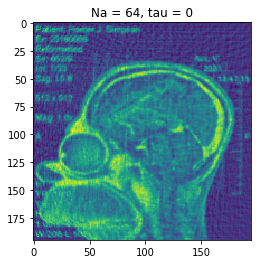

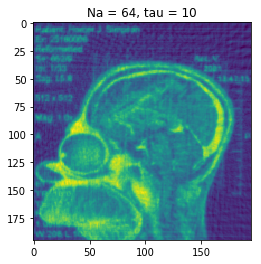

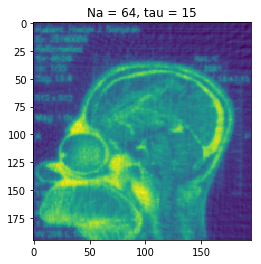

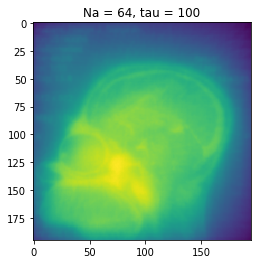

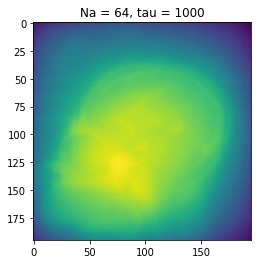

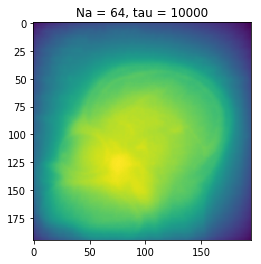

In [35]:
def show_reduced(Na, tau=0):
    img = reconstruct_image_reduced_angles(alphas_195, y_195, 195, Na, tau, tol=1e-5)
    plt.imshow(img)
    plt.title('Na = {}, tau = {}'.format(Na, tau))
    plt.show()
    
for tau in [0, 10, 15, 100, 1000, 10000]:
    show_reduced(64, tau)

Gaussian filtering for comparison

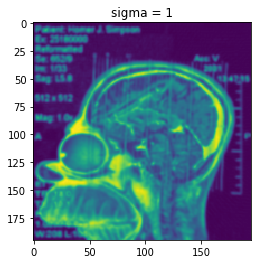

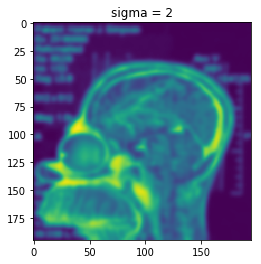

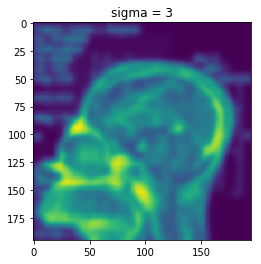

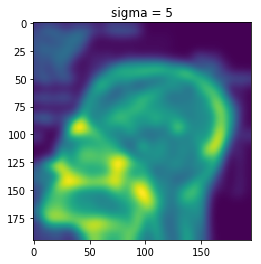

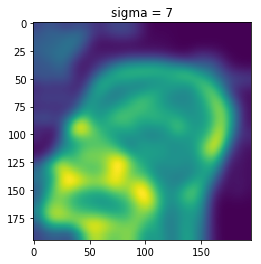

In [45]:
import scipy as sc
from scipy.ndimage.filters import gaussian_filter

def show_filtered(base_img, sigma):
    img = sc.ndimage.filters.gaussian_filter(base_img, sigma=sigma)
    plt.imshow(img)
    plt.title('sigma = {}'.format(sigma))
    plt.show()
    
    
base_img = reconstruct_image(alphas_195, y_195, 195, tau=0, tol=1e-5)

for sigma in [1,2,3,5,7]:
    show_filtered(base_img, sigma)

similarities between methods:
    - Image gets blurry for high values of parameter
    - Text gets unreadable even for quite low values of smoothing parameter
    
differences:
    - gaussian smoothing is local: high intensity regions do not move by filtering
    - Ridge regression causes high intensity regions to shift and eventually conglomerate approximately in the center